In [1]:
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import exposure
from geophys_utils import get_utm_wkt, get_spatial_ref_from_wkt, get_wkt_from_spatial_ref, transform_coords
from dynamic_point_gridding_utils import get_netcdf_datasets, dataset_value_generator, grid_points, hillshade # Code for this example
#from geophys_utils import array2file
#from osgeo import gdal

In [3]:
# Set up search criteria
# Bounding box in GDA94 coordinates
#GDA94_bounds = (118.75, -28.5, 119.5, -27.75) # Sandstone, WA
GDA94_bounds = (141.0, -32.5, 142.0, -31.5) # Broken Hill, NSW (~40k points - takes a while)
#GDA94_bounds = (136.5, -31.0, 137.5, -30.0) # Roxby Downs, SA (possibly some levelling issues?)
keywords = 'point, gravity, point located data, ground digital data, geophysical survey' # Comma-separated list of keywords
grid_variable_name = 'bouguer'

In [4]:
# Calculate extra spatial information about area of interest, including LL, UR points in UTM
GDA94_wkt = get_wkt_from_spatial_ref(get_spatial_ref_from_wkt('EPSG:4283'))
print(GDA94_wkt)

GDA94_centre_coords = [(GDA94_bounds[dim_index] + GDA94_bounds[dim_index+2]) / 2.0 for dim_index in range(2)]
print(GDA94_centre_coords)

utm_wkt = get_utm_wkt(GDA94_centre_coords, GDA94_wkt)
print(utm_wkt)

print(GDA94_bounds)
GDA94_bounding_box = ((GDA94_bounds[0], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[1]), 
                                                      (GDA94_bounds[2], GDA94_bounds[3]), 
                                                      (GDA94_bounds[0], GDA94_bounds[3])
                                                      )
print(GDA94_bounding_box)

reprojected_bounding_box = np.array(transform_coords(GDA94_bounding_box, 
                                                     GDA94_wkt, utm_wkt))
print(reprojected_bounding_box)

utm_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]
print(utm_bounds)

# Expand GDA94 bounding box for point data retrieval to try to ensure complete coverage of UTM bounds

EXTRA=2000 # Extra distance to extend bounds for point data retrieval on each side
expanded_utm_bounding_box = ((utm_bounds[0]-EXTRA, utm_bounds[1]-EXTRA), 
                    (utm_bounds[2]+EXTRA, utm_bounds[1]-EXTRA), 
                    (utm_bounds[2]+EXTRA, utm_bounds[3]+EXTRA), 
                    (utm_bounds[0]-EXTRA, utm_bounds[3]+EXTRA)
                    )
print(expanded_utm_bounding_box)

reprojected_bounding_box = np.array(transform_coords(expanded_utm_bounding_box, 
                                                     utm_wkt, GDA94_wkt))

expanded_GDA94_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]
print(expanded_GDA94_bounds)

GEOGCS["Unknown", DATUM["Unknown", SPHEROID["GRS_1980", 6378137.0, 298.257222101], TOWGS84[0,0,0,0,0,0,0]], PRIMEM["Greenwich", 0], UNIT["degree", 0.017453292519943295], AXIS["Lon", EAST], AXIS["Lat", NORTH]]
[141.5, -32.0]
+proj=utm +zone=54 +south=True +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs
(141.0, -32.5, 142.0, -31.5)
((141.0, -32.5), (142.0, -32.5), (142.0, -31.5), (141.0, -31.5))
[[ 500000.         6404140.88661102]
 [ 593941.20129925 6403700.38552999]
 [ 594966.52663552 6514550.31156295]
 [ 500000.         6514983.35390073]]
[500000.0000000024, 6403700.385529994, 594966.5266355204, 6514983.353900733]
((498000.0000000024, 6401700.385529994), (596966.5266355204, 6401700.385529994), (596966.5266355204, 6516983.353900733), (498000.0000000024, 6516983.353900733))
[140.97870443744847, -32.52201416074145, 142.0324061865531, -31.47788499699225]


In [5]:
# Find all NetCDF paths or OPeNDAP URLs using CSW
netcdf_list = sorted(get_netcdf_datasets(keywords, 
                                         bounding_box=expanded_GDA94_bounds))
print('\n'.join(netcdf_list))
assert len(netcdf_list), 'No datasets found'

Querying CSW
49 matching dataset records found from CSW
49 NetCDF distributions found
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P195099/points/P195099_GNDGRAV/P195099_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196091/points/P196091_GNDGRAV/P196091_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196491/points/P196491_GNDGRAV/P196491_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196600/points/P196600_GNDGRAV/P196600_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196793/points/P196793_GNDGRAV/P196793_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P197006/points/P197006_GNDGRAV/P197006_GNDGRAV.nc
http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/C

In [6]:
# Retrieve all points in bounding box from NetCDF files in UTM projection
# N.B: This may take some time depending on the size of the bounds and the number and size of line datasets
# Lines will be filtered to exclude tielines by using "flight_lines_only=True"
dataset_values = {dataset: dataset_value_dict
                  for dataset, dataset_value_dict in dataset_value_generator([grid_variable_name, 'gridflag'],
                                                              netcdf_list, 
                                                              expanded_GDA94_bounds,
                                                              )
                 }

#print(dataset_values)

1/57 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P195099/points/P195099_GNDGRAV/P195099_GNDGRAV.nc


C:\Users\alex\Anaconda3\lib\site-packages\geophys_utils\_netcdf_point_utils.py:662: UserWarning: WARNING: _FillValue not used since it
cannot be safely cast to variable data type
  result_array = lookup_variable[:][indexing_variable[start_index:end_index][subset_mask]] # Need to index numpy array, not netCDF variable


0/17 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196091/points/P196091_GNDGRAV/P196091_GNDGRAV.nc
2/268 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196491/points/P196491_GNDGRAV/P196491_GNDGRAV.nc
0/9 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
0/8 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196600/points/P196600_GNDGRAV/P196600_GNDGRAV.nc
0/36 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P196793/points/P196793_GNDGRAV/P196793_GNDGRAV.nc
16/1557 points found in bounding box for http://dapds00.nci.org.au/thredds/dodsC/rr2/ground_gravity/Commonwealth/P197006/points/P197006_GNDGRAV/P197006_GNDGRAV.nc
176/4473 points found in bounding box 

[[141.00296  -32.50851 ]
 [141.07295  -32.42351 ]
 [141.08461  -32.49351 ]
 ...
 [140.98515  -31.665817]
 [140.991    -31.674698]
 [140.97986  -31.670088]]
[138.71 206.29 183.22 ... -43.62 -55.39 -59.28]
37731


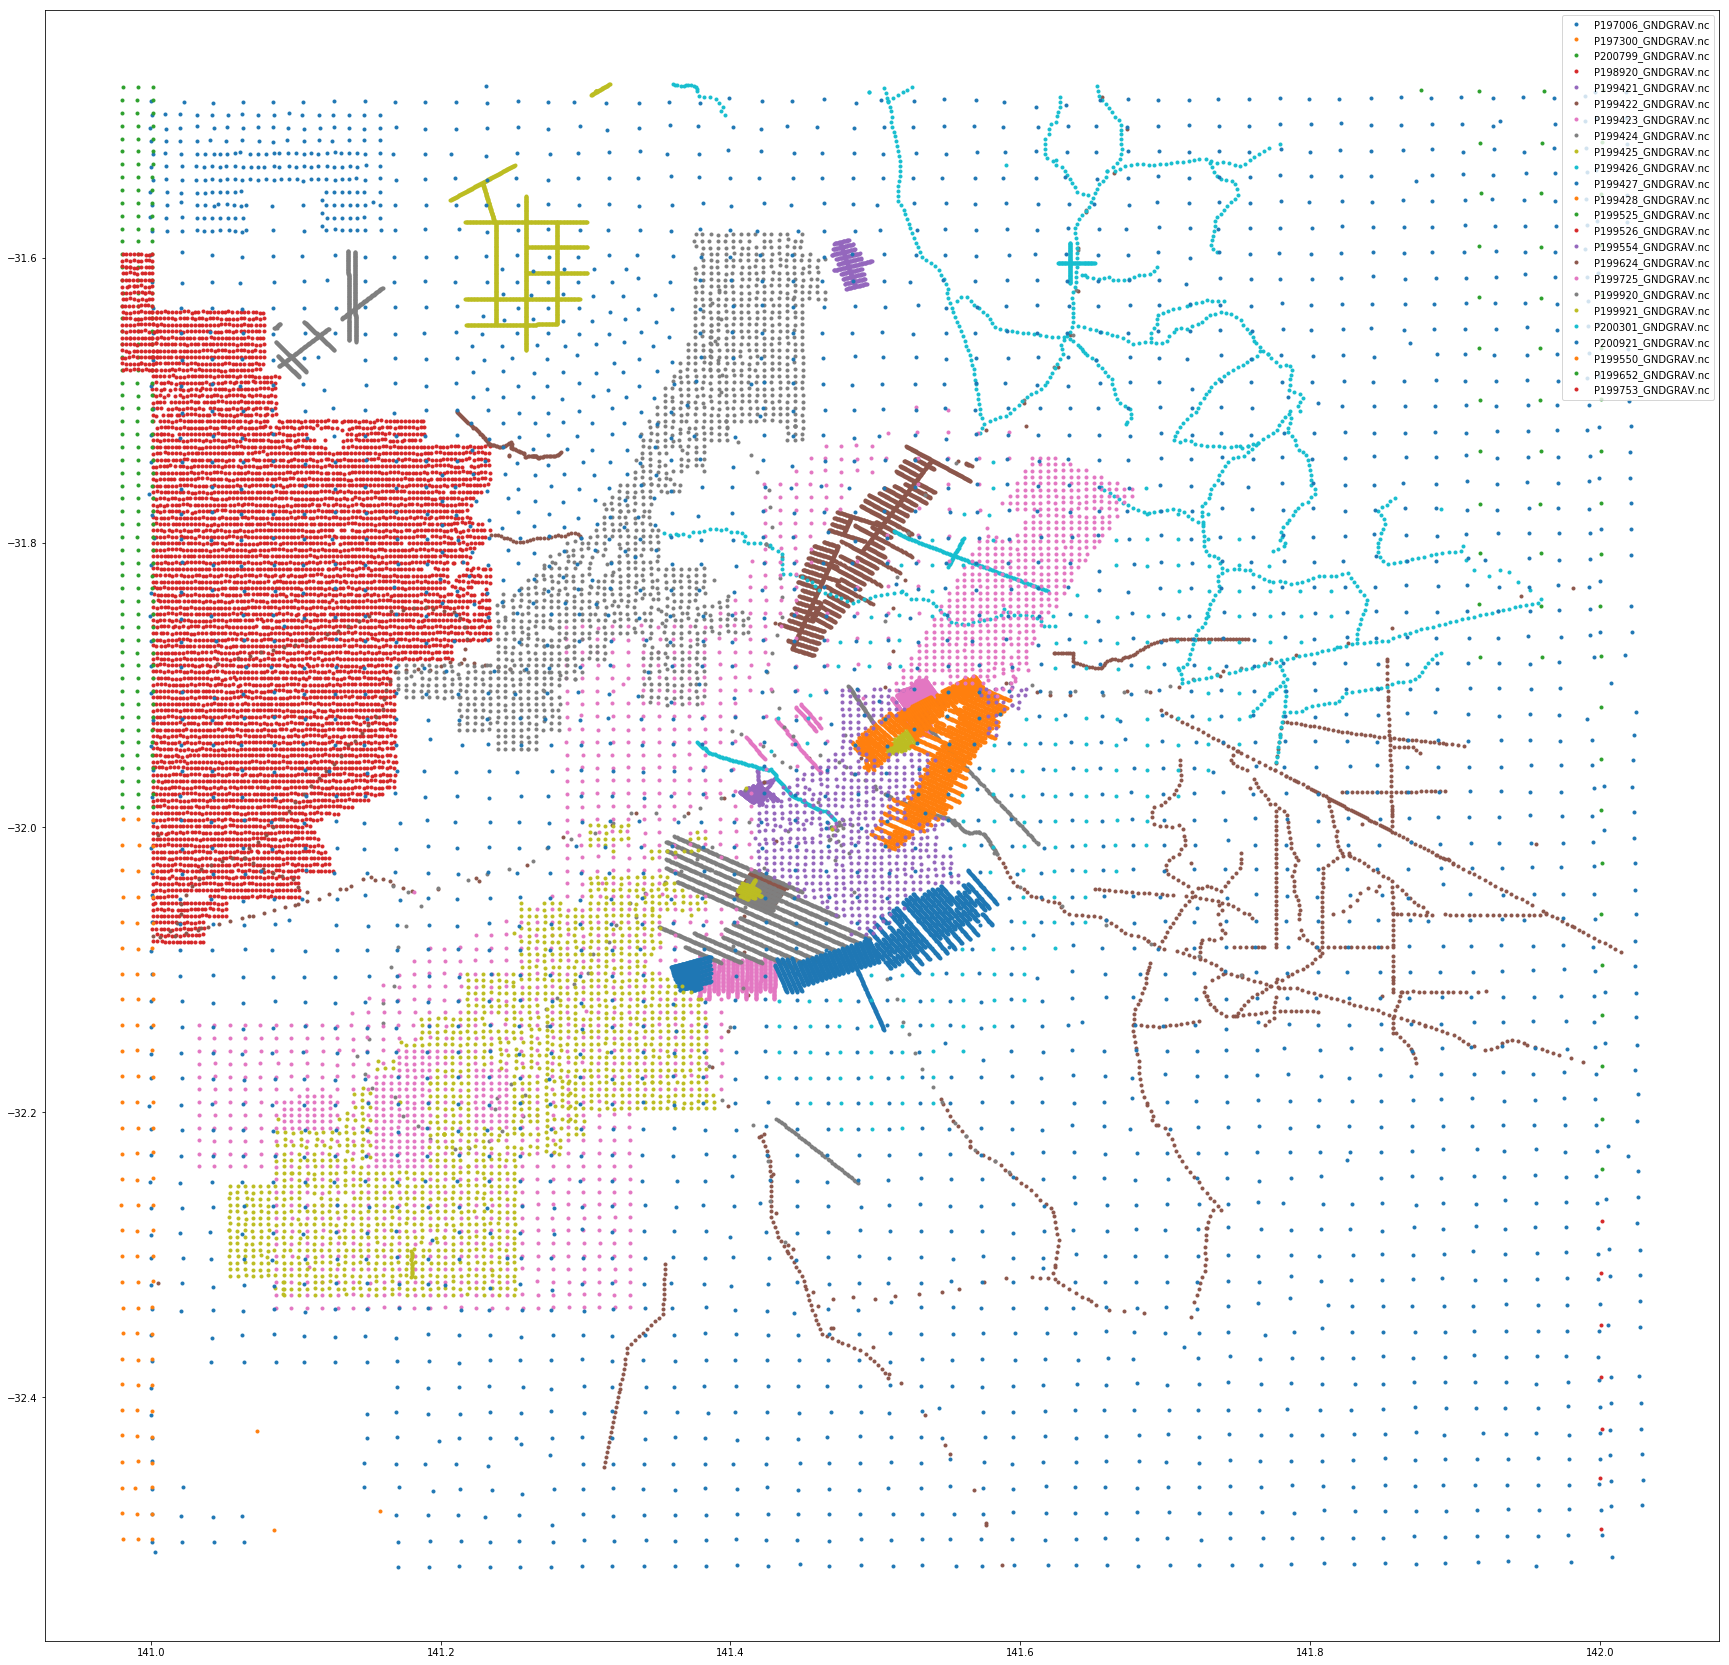

In [7]:
# Filter points from individual datasets and plot them
# Only use points where gridflag == 'Station used in the production of GA grids.'
coordinate_list = []
value_list = []
fig = plt.figure(figsize=(30,30))
for dataset in sorted(dataset_values.keys()):
    #print(dataset)
    #print(len(dataset_values[dataset]['coordinates']))
    #print(len(dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.'))
    gridflag_mask = dataset_values[dataset]['gridflag'] == 'Station used in the production of GA grids.'
    coordinates = dataset_values[dataset]['coordinates'][gridflag_mask]
    if len(coordinates):
        coordinate_list.append(coordinates)
        value_list.append(dataset_values[dataset][grid_variable_name][gridflag_mask])
        plt.plot(coordinates[:,0], coordinates[:,1], '.', label=os.path.basename(dataset))
plt.legend()

all_coordinates = np.concatenate(coordinate_list)
all_values = np.concatenate(value_list)
    
print(all_coordinates)
print(all_values)
print(len(all_values))

In [8]:
#del dataset_values # We have finished with this data structure

In [9]:
# Interpolate points to grid
interpolated_grid, wkt, geotransform = grid_points(coordinates=all_coordinates,
                                 coordinate_wkt=GDA94_wkt,
                                 values=all_values,
                                 grid_wkt=utm_wkt, 
                                 grid_bounds=utm_bounds,
                                 grid_resolution=10, # 10m 
                                 resampling_method='cubic', # 'linear' is quicker, but 'cubic' is prettier
                                 point_step=1
                                 )

Reprojecting coordinates
Generating grid coordinates
Generating point subset mask
Interpolating 37730 points
Interpolation complete


In [10]:
# Print some stats from the grid
print('Shape: ', interpolated_grid.shape)
print('Min:  ', np.nanmin(interpolated_grid))
print('Mean: ', np.nanmean(interpolated_grid))
print('Max:  ', np.nanmax(interpolated_grid))
print('geotransform: ', geotransform)
print('wkt: ', wkt)

Shape:  (11129, 9497)
Min:   -211.21813253241947
Mean:  121.309432813969
Max:   400.1483316457587
geotransform:  [499995.0, 10, 0, 6514985.0, 0, -10]
wkt:  +proj=utm +zone=54 +south=True +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs


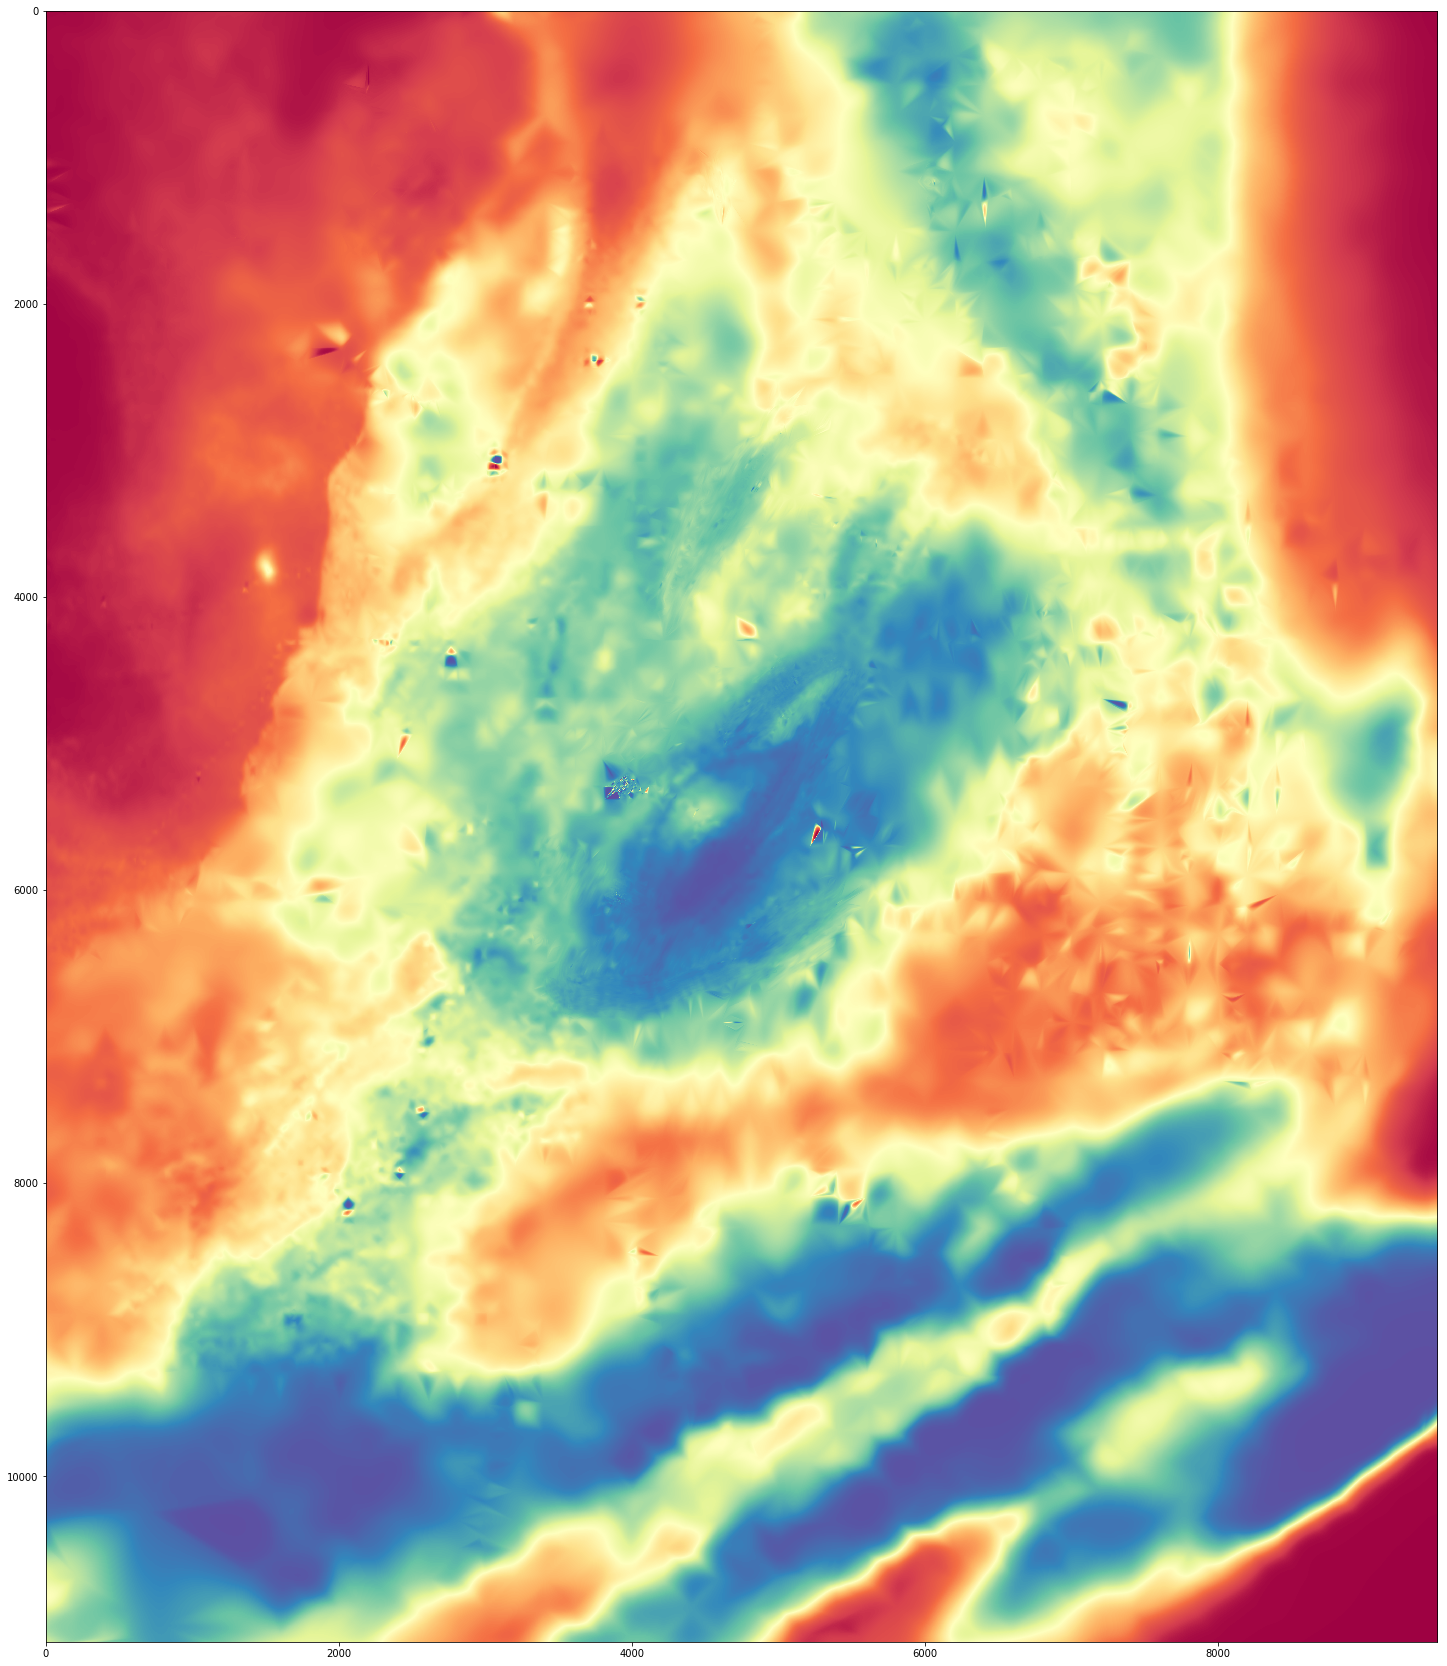

In [11]:
# Plot interpolated grid with histogram equalisation
# Substitute minimum value for NaN values
filled_grid = np.array(interpolated_grid)
filled_grid[np.isnan(filled_grid)] = np.nanmin(filled_grid)
plt.figure(figsize=(30,30))    
plt.imshow(exposure.equalize_hist(filled_grid), cmap='Spectral')

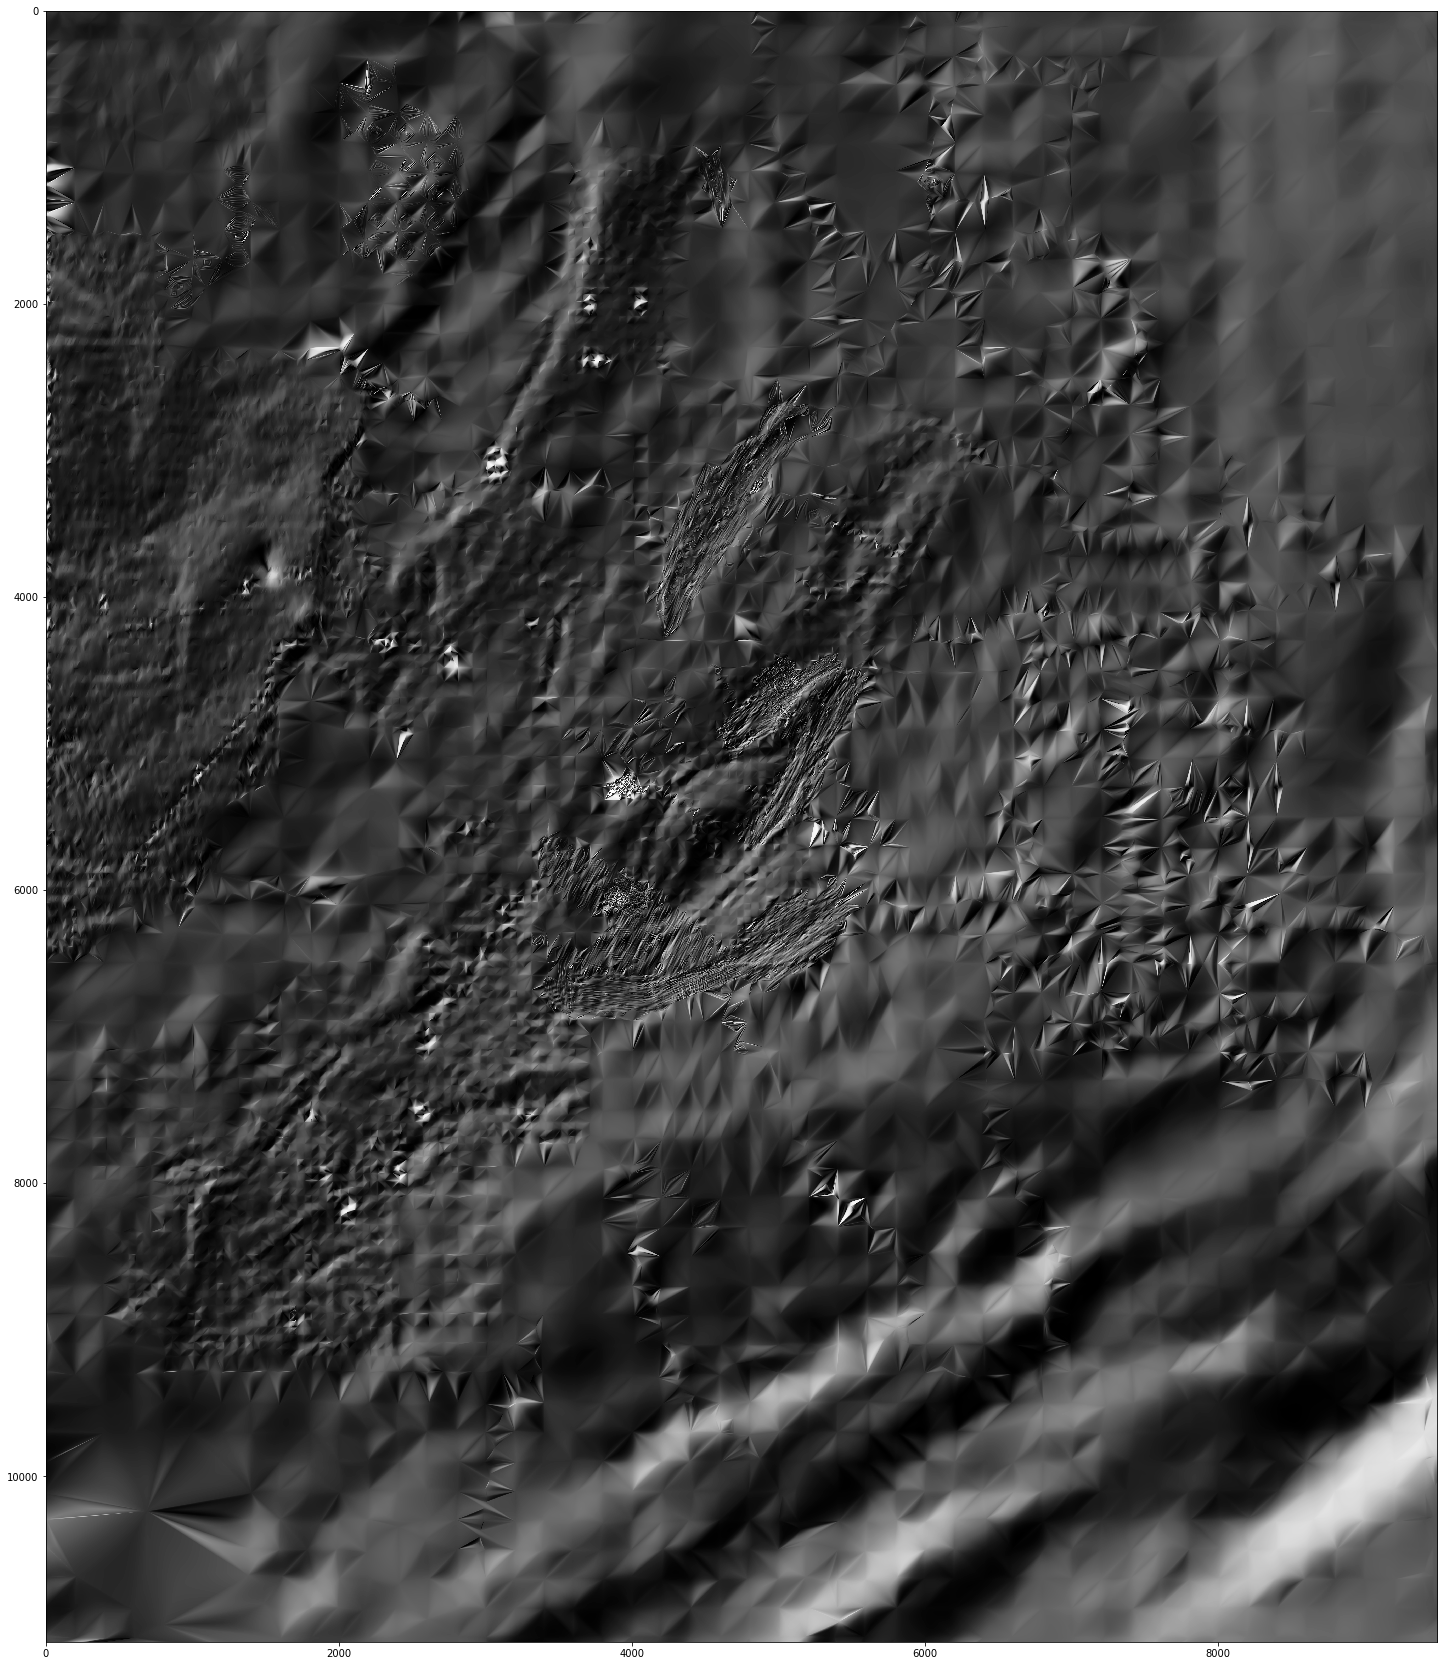

In [12]:
hs_array = hillshade(filled_grid, azimuth=315, angle_altitude=45, vertical_exaggeration=2)
plt.figure(figsize=(30,30))    
plt.imshow(hs_array, cmap='Greys')

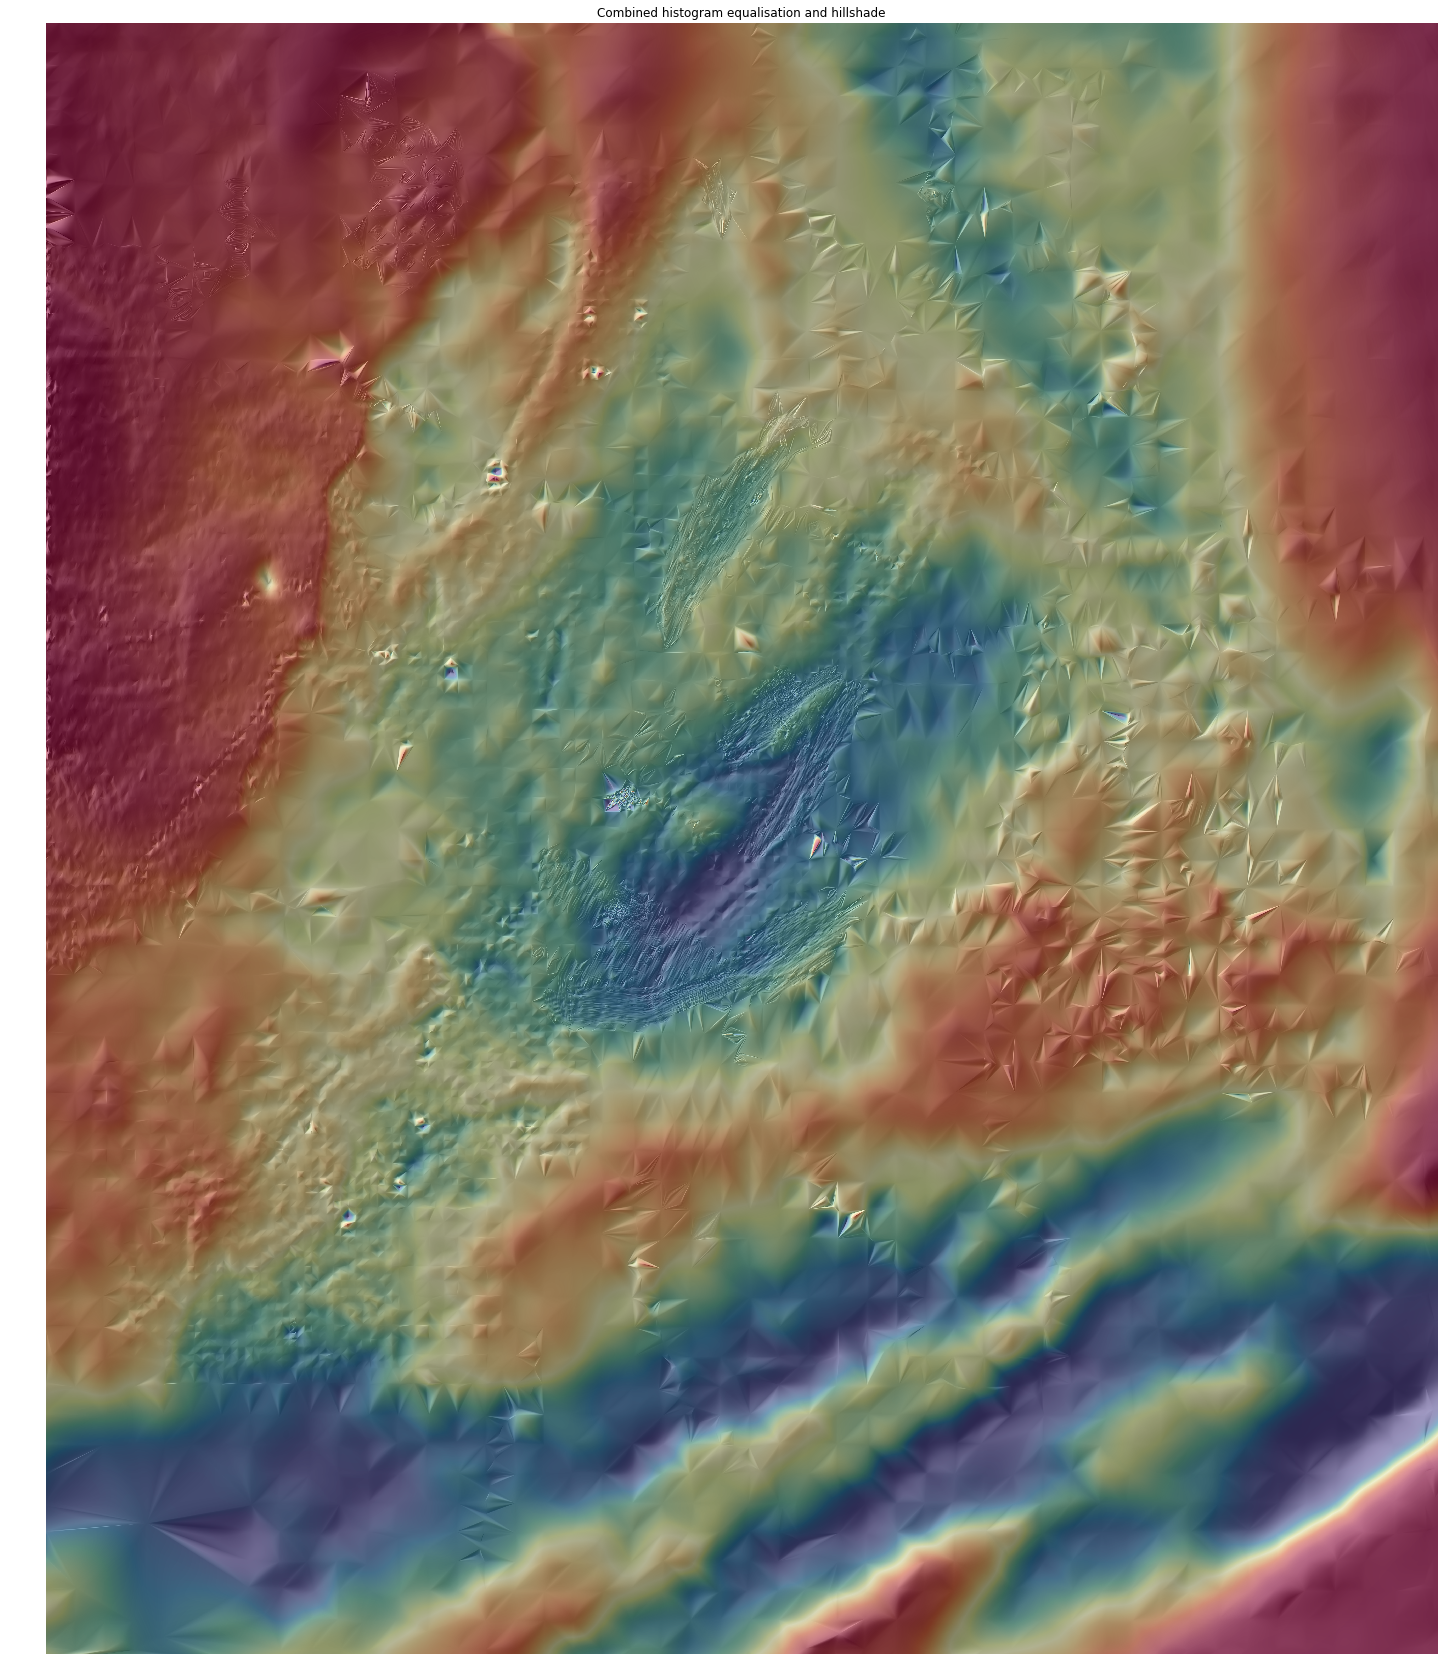

In [13]:
fig, ax = plt.subplots(figsize = (30,30))
ax.imshow(hs_array, cmap='Greys')
ax.imshow(exposure.equalize_hist(filled_grid), cmap='Spectral', alpha=.5) 
ax.set_axis_off()
ax.set(title="Combined histogram equalisation and hillshade");